# CBDC ABM Simulation

This notebook contains a simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid wages for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

## Configuring the model

The parameter_values below can be specified for different simulations.

In [1]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [2]:
parameter_values = (('num_sweeps', '7'),
                    ('num_simulations', '1'),
                    ('num_households', '8'),
                    ('num_firms', '1'),
                    ('num_banks', '2'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '1'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('ach_directory', 'agents/ach/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [3]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [4]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [5]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [6]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [7]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [8]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [9]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [10]:
environment = Environment(environment_directory, identifier)


Import GDP data for calibration. Data is average GDP per firm per employee over 4000 (The mean of the labour distribution).

In [11]:
# importing the module
import json
  
# Opening JSON file
with open('gdp.json') as json_file:
    gdp_calibrate = json.load(json_file)
environment.gdp_calibrate = gdp_calibrate

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [12]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [13]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml

2912.518 new loan from bank_0 to firm_0 for capitalizing bank
{'bank_0': {'assets': {'loans': 2912.518, 'reserves': 0.0}, 'liabilities': {'capital_bank': 2912.518, 'deposits': 0.0, 'open_market_operations': 0.0, 'ach_deposits': 0.0}}}

household_7 took out new loan of 11650.072 at bank_0

1817.26 new loan from bank_0 to firm_0 for capitalizing bank
{'bank_0': {'assets': {'loans': 16379.85, 'reserves': 0.0}, 'liabilities': {'capital_bank': 4729.778, 'deposits': 11650.072, 'open_market_operations': 0.0, 'ach_deposits': 0.0}}}

household_6 took out new loan of 7269.04 at bank_0

1486.221 new loan from bank_0 to firm_0 for capitalizing bank
{'bank_0': {'assets': {'loans': 25135.111, 'reserves': 0.0}, 'liabilities': {'capital_bank': 6215.999, 'deposits': 18919.112, 'open_market_operations': 0.0, 'ach_deposits': 0.0}}}

household_4 took out new loan of 5944.884 at bank_0

3637.1445 new loan from bank_1 to firm_0 for capitalizing bank
{'bank_1': {'assets': {'loan

Check to see if all agents balance sheets are consistent. Rounding erros may result in not all agents having consistent balance sheets.

In [14]:
house = True
for houses in environment.households:
    house *= houses.check_consistency()
if house:
    print("All households have consistent balance sheets")
else:
    print("Not all households have consistent balance sheets")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.ach[0].check_consistency():
    print("ACH has consistent balance sheets")
elif environment.ach[0].check_consistency() is False:
    print("ACH does not consistent balance sheets")

if environment.central_bank[0].check_consistency():
    print("Central Bank has consistent balance sheets")
elif environment.central_bank[0].check_consistency() is False:
    print("Central Bank does not consistent balance sheets")

Not all households have consistent balance sheets
Not all firms have consistent balance sheets
Not all banks have consistent balance sheets
ACH has consistent balance sheets
Central Bank has consistent balance sheets


Print Balance Sheet for one randomly selected household, firm and bank, and central bank.

In [15]:
import pandas as pd
house = environment.households[0]
balance_sheet = house.balance_sheet()
mark_h = pd.DataFrame.from_dict(balance_sheet[house.identifier], orient="columns")
mark_h.loc['Total']= round(mark_h.sum(), 0)

for house in environment.households[1:]:
    balance_sheet = house.balance_sheet()
    mark = pd.DataFrame.from_dict(balance_sheet[house.identifier], orient="columns")
    mark.loc['Total']= round(mark.sum(), 0)
    mark_h.add(mark)
print("Total Household balance sheet")
print(mark_h)

firm = environment.firms[0]
balance_sheet = firm.balance_sheet()
mark_f = pd.DataFrame.from_dict(balance_sheet[firm.identifier], orient="columns")
mark_f.loc['Total']= round(mark_f.sum(), 0)

for firm in environment.firms[1:]:
    balance_sheet = firm.balance_sheet()
    mark = pd.DataFrame.from_dict(balance_sheet[firm.identifier], orient="columns")
    mark.loc['Total']= round(mark.sum(), 0)
    mark_f.add(mark)
print("Total Firms balance sheet")
print(mark_f)

bank = environment.banks[0]
balance_sheet = bank.balance_sheet()
mark_b = pd.DataFrame.from_dict(balance_sheet[bank.identifier], orient="columns")
mark_b.loc['Total']= round(mark_b.sum(), 0)

for bank in environment.banks[1:]:
    balance_sheet = bank.balance_sheet()
    mark = pd.DataFrame.from_dict(balance_sheet[bank.identifier], orient="columns")
    mark.loc['Total']= round(mark.sum(), 0)
    mark_b.add(mark)
print("Total Banks balance sheet")
print(mark_b)

ach = environment.ach[0]
balance_sheet = ach.balance_sheet()
mark = pd.DataFrame.from_dict(balance_sheet[ach.identifier], orient="columns")
mark.loc['Total']= round(mark.sum(), 0)
print(f"{ach.identifier} balance sheet")
print(mark)

central_bank = environment.central_bank[0]
balance_sheet = central_bank.balance_sheet()
mark = pd.DataFrame.from_dict(balance_sheet[central_bank.identifier], orient="columns")
mark.loc['Total']= round(mark.sum(), 0)
print(f"{central_bank.identifier} balance sheet")
print(mark)

Total Household balance sheet
                       assets  liabilities
capital_firm       2912.51800          NaN
capital_bank       2912.51800          NaN
deposits           8394.37184          NaN
cbdc                  0.00000          NaN
bank_notes            0.00000          NaN
output_agreement   5840.00000          NaN
equity                    NaN   1881.69209
loans                     NaN  11650.07200
wage_agreement            NaN   5840.12168
Total             20059.00000  19372.00000
Total Firms balance sheet
                        assets   liabilities
fixed_assets       35614.75500           NaN
deposits           79094.99250           NaN
cbdc                   0.00000           NaN
wage_agreement     35706.99009           NaN
capital_firm               NaN   17807.37750
loans                      NaN   89129.12259
output_agreement           NaN   35707.00000
Total             150417.00000  142644.00000
Total Banks balance sheet
                              assets    

In [16]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [17]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      CBDC_Payments  Deposits_Payments  Total Output
Step                                                
1                 0      106844.265000           0.0
2                 0      147773.265610       35707.0
3                 0      168808.508023       35707.0
      CBDC_Payments  Deposits_Payments  Total Output
Step                                                
4                 0      181294.478673       35707.0
5                 0      191418.965340       35707.0
6                 0      202297.320409       35707.0
7                 0      241307.000699       35707.0


In [18]:
import matplotlib.pyplot as plt

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_86401/2999196067.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  thesis_data_plot = thesis_data.drop(["Total Output"], 1).drop([1])


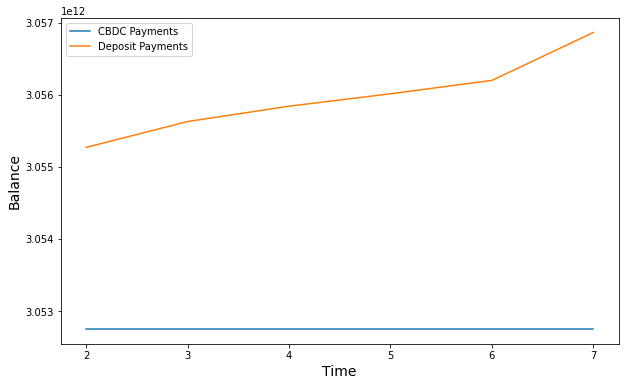

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
thesis_data_plot = thesis_data.drop(["Total Output"], 1).drop([1])
thesis_data_plot = thesis_data_plot.transform(lambda CBDC_Payments: CBDC_Payments * gdp_calibrate[0]["Num_Firms"]/800 + gdp_calibrate[0]["GDP"])
ax.plot(thesis_data_plot.index, thesis_data_plot)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['CBDC Payments', 'Deposit Payments'])

fig.savefig('figures/Deposits_CBDC_Payments.png')

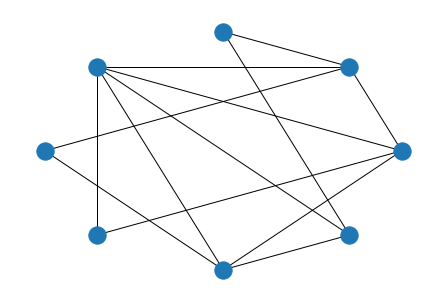

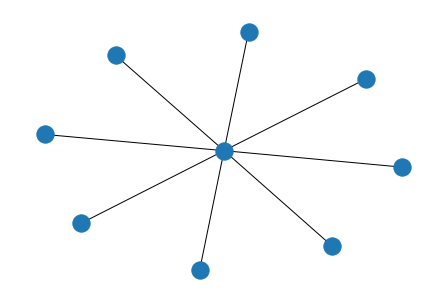

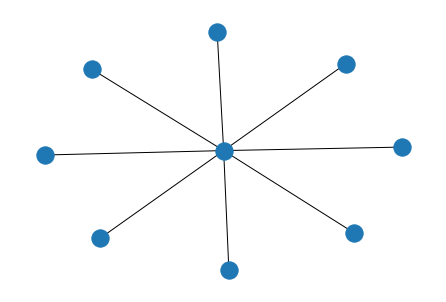

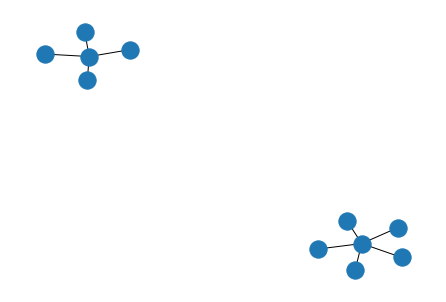

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Plot social network
nx.draw_shell(environment.social_network)
plt.savefig('figures/social_network.png')
plt.show()
# Plot employment network
nx.draw(environment.employment_network)
plt.savefig('figures/employment_network.png')
plt.show()
# Plot consumption network
nx.draw(environment.consumption_network)
plt.savefig('figures/consumption_network.png')
plt.show()
# Plot bank network
nx.draw(environment.bank_network)
plt.savefig('figures/bank_network.png')
plt.show()
